In [1]:
%%capture
#@markdown # DeepLab training
!python -m pip install onnx
!python -m pip install abraia
!python -m pip install ultralytics

import os
if not os.getenv('ABRAIA_ID') and not os.getenv('ABRAIA_KEY'):
    abraia_id = ''  #@param {type: "string"}
    abraia_key = ''  #@param {type: "string"}
    %env ABRAIA_ID=$abraia_id
    %env ABRAIA_KEY=$abraia_key

from abraia import training, detect

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


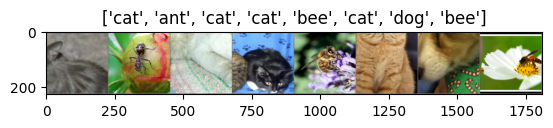

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 207MB/s]


Epoch 0/24
----------
train Loss: 1.0596 Acc: 0.5353
val Loss: 0.5378 Acc: 0.7993

Epoch 1/24
----------
train Loss: 0.4707 Acc: 0.8587
val Loss: 0.1867 Acc: 0.9628

Epoch 2/24
----------
train Loss: 0.4579 Acc: 0.8290
val Loss: 0.1469 Acc: 0.9703

Epoch 3/24
----------
train Loss: 0.3601 Acc: 0.8848
val Loss: 0.1190 Acc: 0.9777

Epoch 4/24
----------
train Loss: 0.3049 Acc: 0.8996
val Loss: 0.0944 Acc: 0.9814

Epoch 5/24
----------
train Loss: 0.3496 Acc: 0.8699
val Loss: 0.0857 Acc: 0.9777

Epoch 6/24
----------
train Loss: 0.3790 Acc: 0.8587
val Loss: 0.1232 Acc: 0.9665

Epoch 7/24
----------
train Loss: 0.2665 Acc: 0.8959
val Loss: 0.0768 Acc: 0.9777

Epoch 8/24
----------
train Loss: 0.2464 Acc: 0.9182
val Loss: 0.0766 Acc: 0.9777

Epoch 9/24
----------
train Loss: 0.2862 Acc: 0.8885
val Loss: 0.0748 Acc: 0.9777

Epoch 10/24
----------
train Loss: 0.2214 Acc: 0.9442
val Loss: 0.0756 Acc: 0.9777

Epoch 11/24
----------
train Loss: 0.2825 Acc: 0.9071
val Loss: 0.0781 Acc: 0.9740

Ep

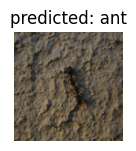

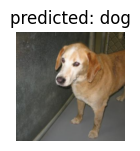

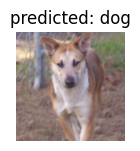

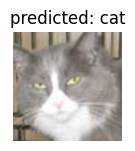

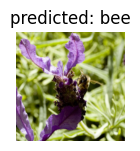

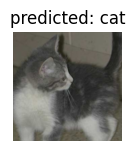

In [6]:
#@markdown ## Dashboard

import glob
from PIL import Image

#os.environ['YOLO_VERBOSE'] = 'False'

from ultralytics import YOLO

def sorted_folders(dir):
    items = [os.path.join(dir, name) for name in os.listdir(dir)]
    sorted_items = sorted(items, key=os.path.getctime)
    return sorted_items

def plot_results(src, results):
    im = Image.open(src).convert('RGB')
    detect.render_results(im, results)
    display(im)


import ipywidgets as widgets
from IPython.display import display
from IPython.display import Image as show_image

projects = training.load_projects()

dropdown_project = widgets.Dropdown(description='Project', options=projects, value=projects[0])
text_classes = widgets.Text(description='Classes', value='')
text_task = widgets.Text(description='Task', value='')
label_status = widgets.Label(value='')

def dropdown_project_eventhandler(change):
    output_train.clear_output()
    output_labels.clear_output()
    output_pred.clear_output()
    label_status.value = 'Loading annotations...'
    dataset = dropdown_project.value
    annotations = training.load_annotations(dataset)
    classes = training.load_labels(annotations)
    task = training.load_task(annotations)
    text_classes.value = str(classes or '')
    text_task.value = str(task or '')
    if len(classes) and task:
        label_status.value = 'Annotations loaded.'
        button_train.disabled = False
    else:
        label_status.value = 'Not annotated.'
        button_train.disabled = True

dropdown_project.observe(dropdown_project_eventhandler, names='value')

button_train = widgets.Button(description='Train', disabled=True)
output_train = widgets.Output(layout={'border': '1px solid black', 'width': '50%', 'height': '360px', 'overflow': 'auto'})

output_labels = widgets.Output()
output_pred = widgets.Output()

def button_train_eventhandler(obj):
    #output_train.clear_output()
    #with output_train:
    button_train.disabled = True
    dataset = dropdown_project.value
    classes = eval(text_classes.value)
    task = text_task.value
    epochs = 50
    imgz = 640
    #model_path = f'{dataset}/{model_name}.onnx'
    #model_type = dropdown_type.value
    #batch_size = 32
    if task == 'classify':
        model_name = 'model_ft'
        label_status.value = 'Creating dataset...'
        dataloaders, classes = training.t_create_dataset(dataset)
        training.t.visualize_data(dataloaders['train'])
        label_status.value = 'Training model...'
        model = training.t_train_model(dataloaders, classes)
        training.t.visualize_model(model, dataloaders['val'])
        training.t_save_model(model, model_name, dataset, classes)
        label_status.value = 'Model saved.'
    else:
        label_status.value = 'Creating dataset...'
        training.create_dataset(dataset, task, classes)
        label_status.value = 'Training model...'
        model, model_name = training.train_model(dataset, task, epochs=epochs, imgsz=imgz)
        training.save_model(model, model_name, dataset, task, classes, imgsz=imgz)
        label_status.value = 'Model saved.'
        folders = sorted_folders(f"runs/{task}/")
        folder = folders[-1]
        print(folder, folders)
        with output_labels:
            display(show_image(filename=f"{folder}/val_batch0_labels.jpg"))
        with output_pred:
            display(show_image(filename=f"{folder}/val_batch0_pred.jpg"))
        # Random test...
        src = glob.glob(f"{dataset}/test/*/*.png")[0]
        results = training.run_model(model, src)
        plot_results(src, results)
    button_train.disabled = False

button_train.on_click(button_train_eventhandler)

hbox_output = widgets.HBox([output_labels, output_pred])
#hbox_output = widgets.HBox([output_train, output_labels, output_pred])
dashboard = widgets.VBox([dropdown_project, text_classes, text_task, label_status, button_train, hbox_output])
display(dashboard)
